# Compare Scores to each other

## Load Environment

In [1]:
import numpy as np
import pandas as pd

import scanpy as sc
import squidpy as sq

In [2]:
from liana.mt.sp import lr_basis
import liana as li

In [291]:
function_names = li.mt.sp.show_functions()['name']
function_names = function_names[~function_names.str.contains('masked')]

In [282]:
visium_datasets = {'posterior1': "V1_Mouse_Brain_Sagittal_Posterior",
                   'posterior2': "V1_Mouse_Brain_Sagittal_Posterior_Section_2",
                   'anterior1': "V1_Mouse_Brain_Sagittal_Anterior",
                   'anterior2': "V1_Mouse_Brain_Sagittal_Anterior_Section_2"
                   }
# {'heart':"V1_Human_Heart", 'lymph':"V1_Human_Lymph_Node", 'prostate':"Visium_FFPE_Human_Normal_Prostate"}

In [330]:
adatas = dict()

for dataset in visium_datasets.keys():
    print(dataset)
    
    adata = sq.datasets.visium(sample_id=visium_datasets[dataset])
    adata.var_names_make_unique()

    sc.pp.filter_cells(adata, min_counts=100)
    sc.pp.filter_genes(adata, min_cells=20)

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata, inplace=True)
    sc.pp.log1p(adata)
    
    ## Run LR basis
    for function_name in function_names:
        print(function_name)
        
        li.mt.sp.get_spatial_proximity(adata=adata, parameter=100, bypass_diagonal=False, cutoff=0.2)
        lr_basis(adata, resource_name="mouseconsensus", 
                 function_name=function_name, obsm_added=function_name, key_added=function_name,
                 use_raw=False)
        
        sq.gr.spatial_neighbors(adata, n_rings=1, coord_type="grid", n_neighs=6, set_diag=True)
        lr_basis(adata, resource_name="mouseconsensus", 
                 function_name=function_name, obsm_added=function_name + '(grid)', key_added= function_name + '(grid)',
                 use_raw=False, proximity_key="spatial_connectivities")
    
    adatas[dataset] = adata

posterior1


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


pearson
spearman
cosine
jaccard
morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


posterior2


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


pearson
spearman
cosine
jaccard
morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


anterior1


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


pearson
spearman
cosine
jaccard
morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


anterior2


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.


pearson
spearman
cosine
jaccard
morans


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/liana/method/sp/_spatial_pipe.py:473: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Calculate similatiry between all LR datas

In [337]:
import torch
import torch.nn.functional as F
from itertools import product

In [340]:
function_names2 = list(np.array(function_names)[~function_names.str.contains('morans')] + '(grid)')

In [341]:
function_combos = list(product(list(function_names) + function_names2, list(function_names) + function_names2))

In [342]:
sim = dict()

for key in adatas.keys():
    adata = adatas[key]
    sim[key] = dict()
    
    for combo in function_combos:
        mat1 = torch.tensor(adata.obsm[combo[0]].values)
        mat2 = torch.tensor(adata.obsm[combo[1]].values)
        
        cosine_sim = F.cosine_similarity(mat1, mat2, dim=0)
        cosine_sim = cosine_sim.detach().numpy()
        
        sim[key][combo] = cosine_sim.mean()

In [359]:
sim_df = pd.DataFrame(sim)
sim_df['mean_sim'] = sim_df.mean(axis=1)
sim_df.reset_index(names=['function1', 'function2'], inplace=True)
sim_df = sim_df[['function1', 'function2', 'mean_sim']]

In [360]:
import plotnine as p9

In [361]:
# sim_df = sim_df[~(sim_df['function1'].str.contains('morans') ) & ~(sim_df['function2'].str.contains('morans'))]

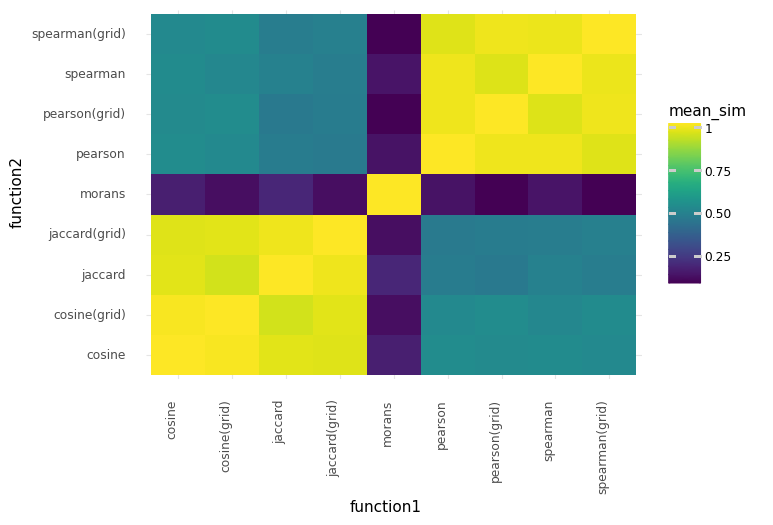

<ggplot: (8763642680251)>

In [362]:
(p9.ggplot(sim_df, p9.aes(x='function1', y='function2', fill='mean_sim')) +
 p9.geom_tile() +
 p9.theme_minimal() +
 p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
 )